In [1]:
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import numpy as np
from dataset import *
#from models import *
from encoder import *
import torch
import math

c:\anaconda3\envs\master\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
model_weights_path = glob.glob(f"trained_models/sen2_baseline_wavelet_final_seed3/best_iou*")[0]
model = smp.Unet(
            encoder_name="dual_encoder_wav",
            encoder_depth=5,
            encoder_weights=None,
            classes=2,
            decoder_attention_type="scse",
            activation='sigmoid',
        )
model = model.cuda()
model.eval()

cp = torch.load(model_weights_path)
model.load_state_dict(cp["model_state_dict"])
print(f"Loaded {model_weights_path} at epoch {cp['epoch_num']}")

# Loading data from precomputed dataset
path = "C:/Users/The Son/Desktop/Uni/Berlin/Masterarbeit/Data/model_data/test"
# Data/ms-dataset-chips\\95eff095-c3e9-4c12-bfde-1708b7e19bae\\s2\\S2A_MSIL1C_20170528T050611_N0205_R076_T44NNP_20170528T050606_00960-03063\\B12.tif'
data = np.load(f"{path}/150.npz", allow_pickle=True)
data = data["arr_0"][0]
X = data["image"]
X = torch.tensor(np.expand_dims(X, axis=0))

amps = data["amplitude"]
phases = data["phase"]
wavelets = torch.tensor(np.expand_dims(data["wavelet"], axis=0)).cuda(non_blocking=True).float()

X = X.cuda(non_blocking=True).float()
ap = torch.tensor(np.expand_dims(np.concatenate([amps, phases], axis=0), axis=0)).cuda(non_blocking=True).float()

model.encoder.wav = wavelets
results = model(X)


Loaded trained_models/sen2_baseline_wavelet_final_seed3\best_iou_36_0.7744.pt at epoch 36


In [3]:
def visualize_channels(tensor, num_channels=None):
    # Remove the batch dimension (convert [1, C, H, W] -> [C, H, W])
    tensor_squeezed = tensor.squeeze(0)
    
    # If num_channels is not provided, visualize all channels
    if num_channels is None:
        num_channels = tensor_squeezed.shape[0]
    
    # Limit the number of channels to the number of available channels
    num_channels = min(tensor_squeezed.shape[0], num_channels)
    
    # Calculate the grid size (e.g., 3x3 for 9 channels, 4x4 for 16 channels)
    grid_size = math.ceil(math.sqrt(num_channels))
    
    # Create a plot with a grid of subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    
    # Visualize each selected channel
    for i in range(num_channels):
        ax = axes[i]
        ax.imshow(tensor_squeezed[i].detach().cpu().numpy(), cmap='viridis')
        ax.set_title(f"Channel {i+1}")
        ax.axis('off')
    
    # Turn off the remaining empty subplots (if any)
    for j in range(num_channels, grid_size * grid_size):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

torch.Size([1, 16, 512, 512])


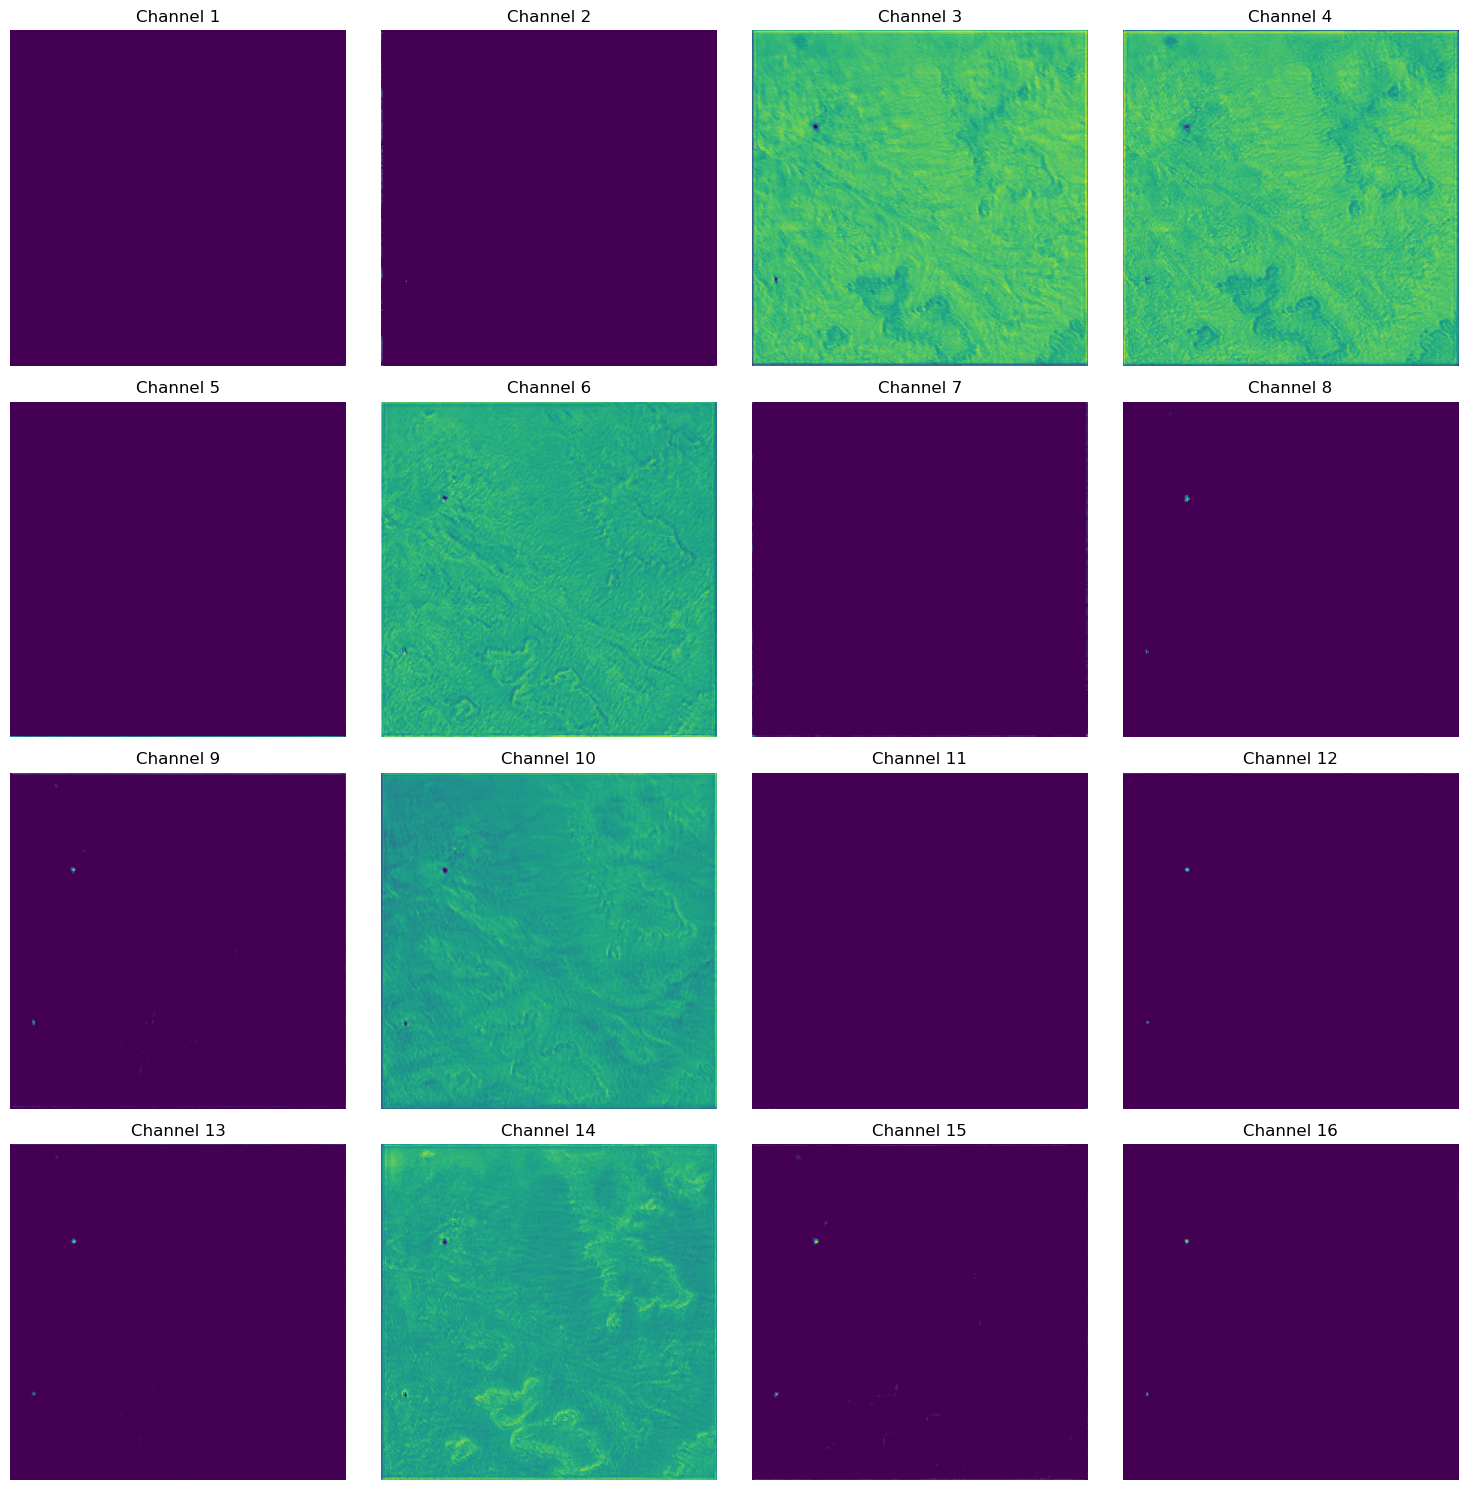

In [ ]:
encoder = model.encoder(X)
decoder = model.decoder(*encoder)
visualize_channels(encoder[0])


In [10]:
def get_decoder_layers(model1, data_input_1):
    # Forward pass through both encoders
    encoder_1 = model1.encoder(data_input_1)

    # Lists to store the intermediate outputs of the decoder blocks for both models
    decoder_block_outputs1 = []

    # Hook function to capture outputs from each decoder block of model1
    def hook_fn1(module, input, output):
        decoder_block_outputs1.append(output)

    # Register hooks for decoder blocks in both models
    for block in model1.decoder.blocks:
        block.register_forward_hook(hook_fn1)

    # Forward pass through the decoders (the hooks will capture the intermediate outputs)
    decoder_1 = model1.decoder(*encoder_1)

    return decoder_1, decoder_block_outputs1

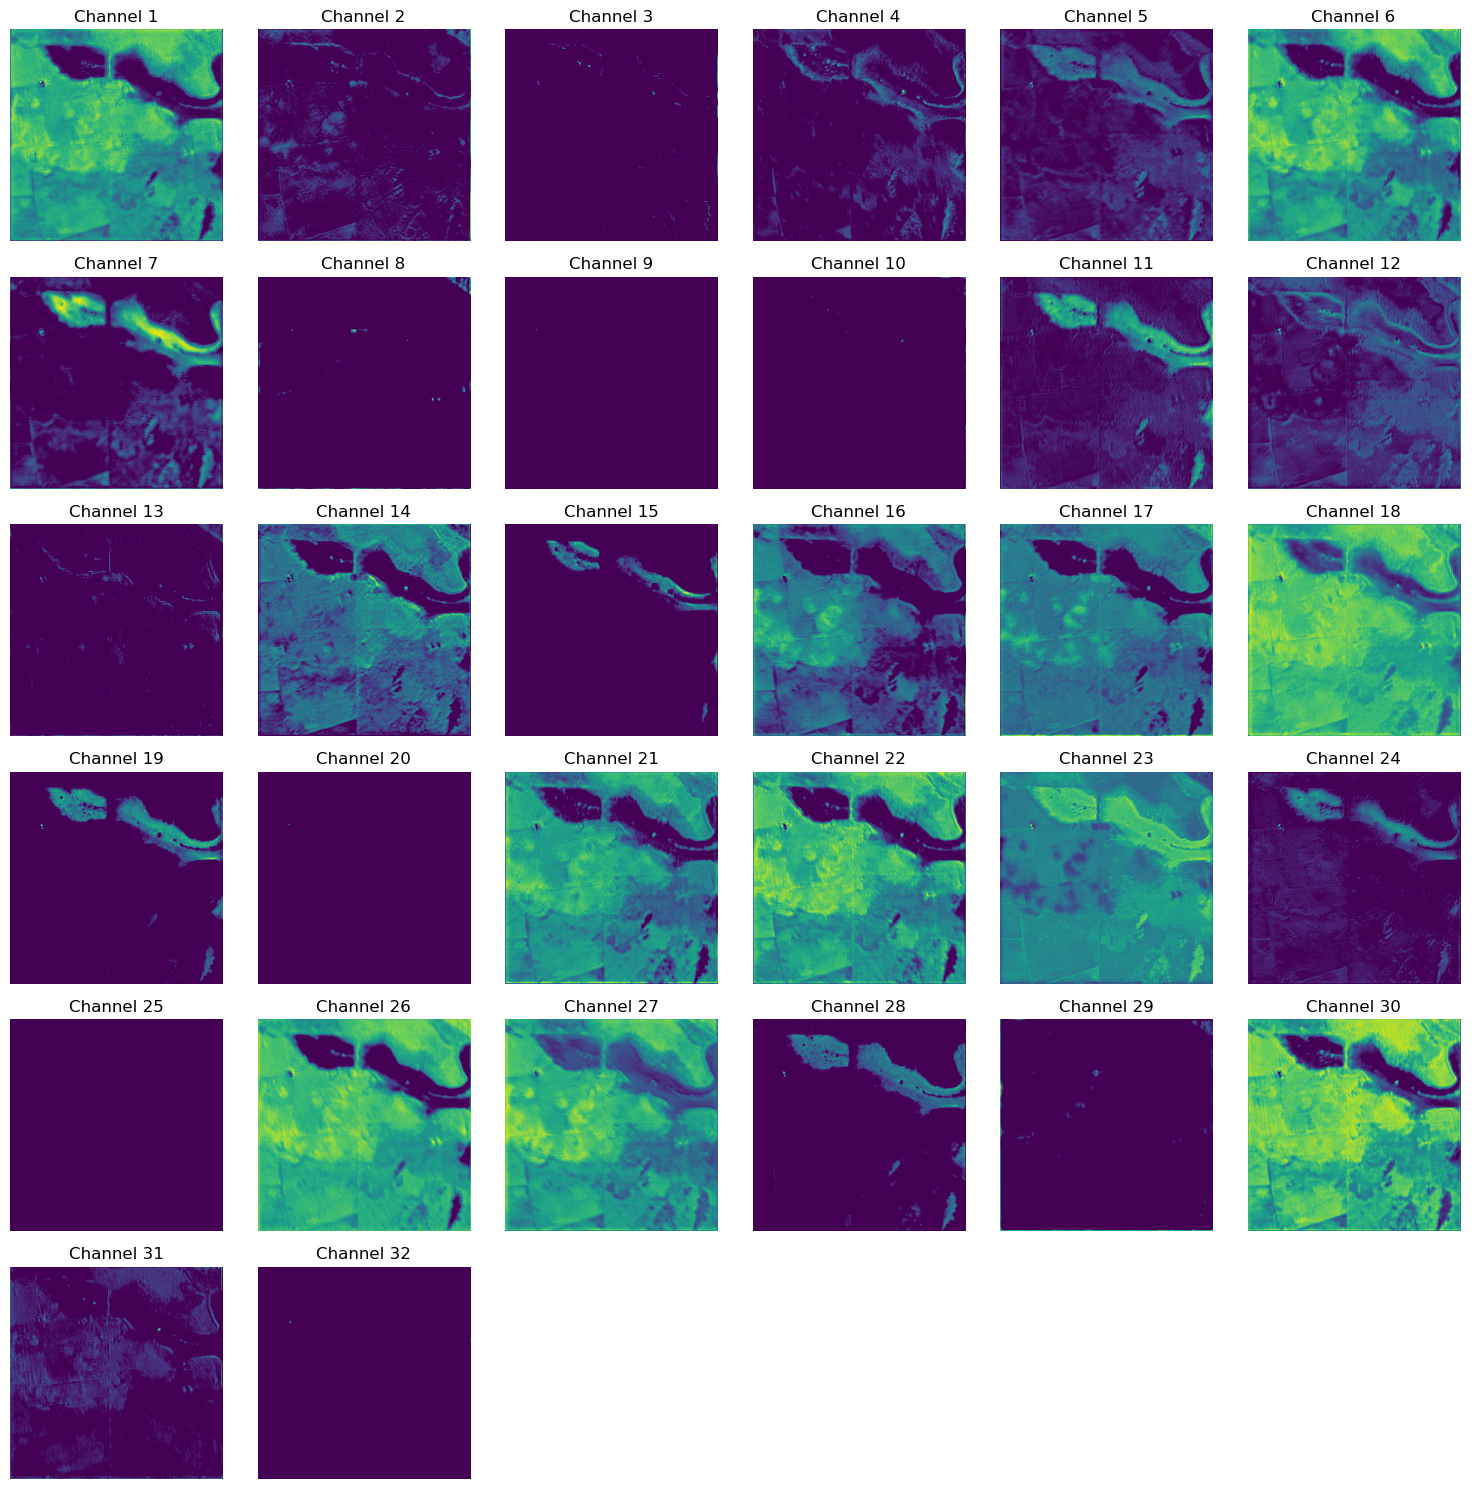

In [19]:
_, layers = get_decoder_layers(model, X)
visualize_channels(layers[3])

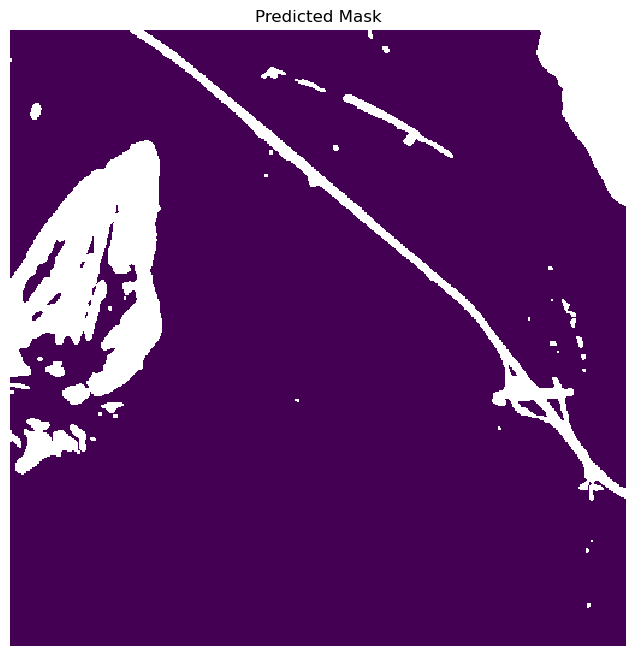

torch.Size([1, 6, 512, 512])


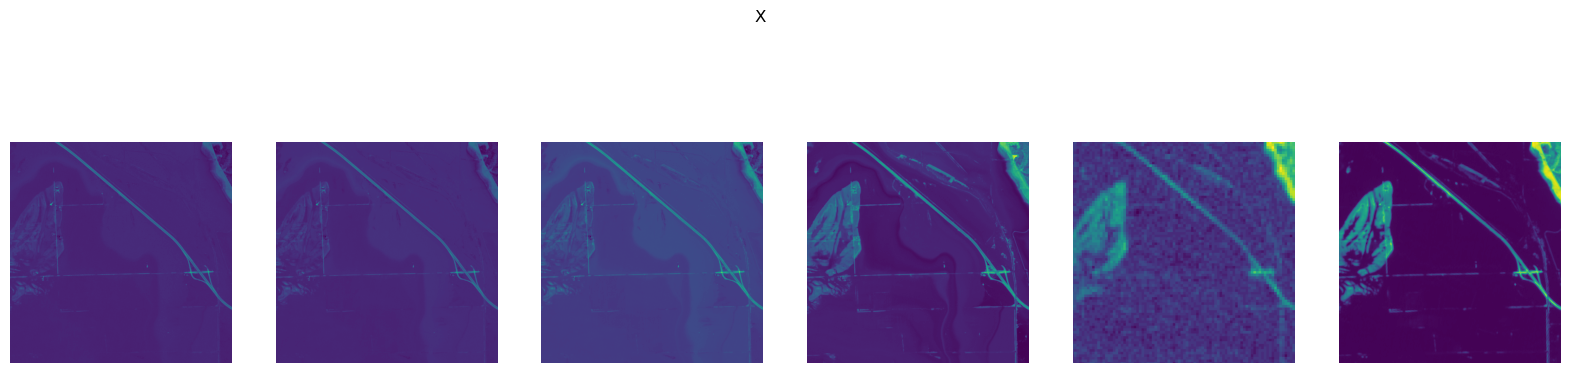

torch.Size([1, 12, 512, 512])


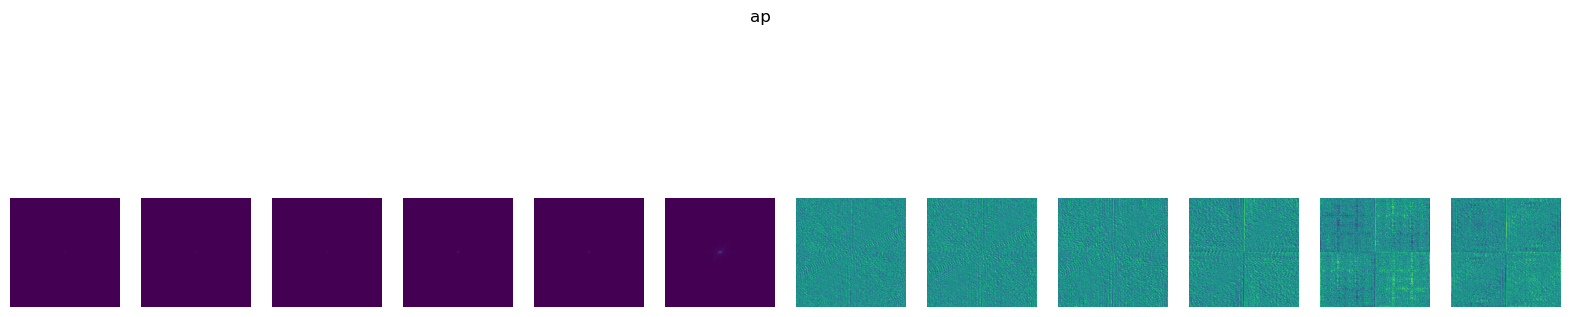

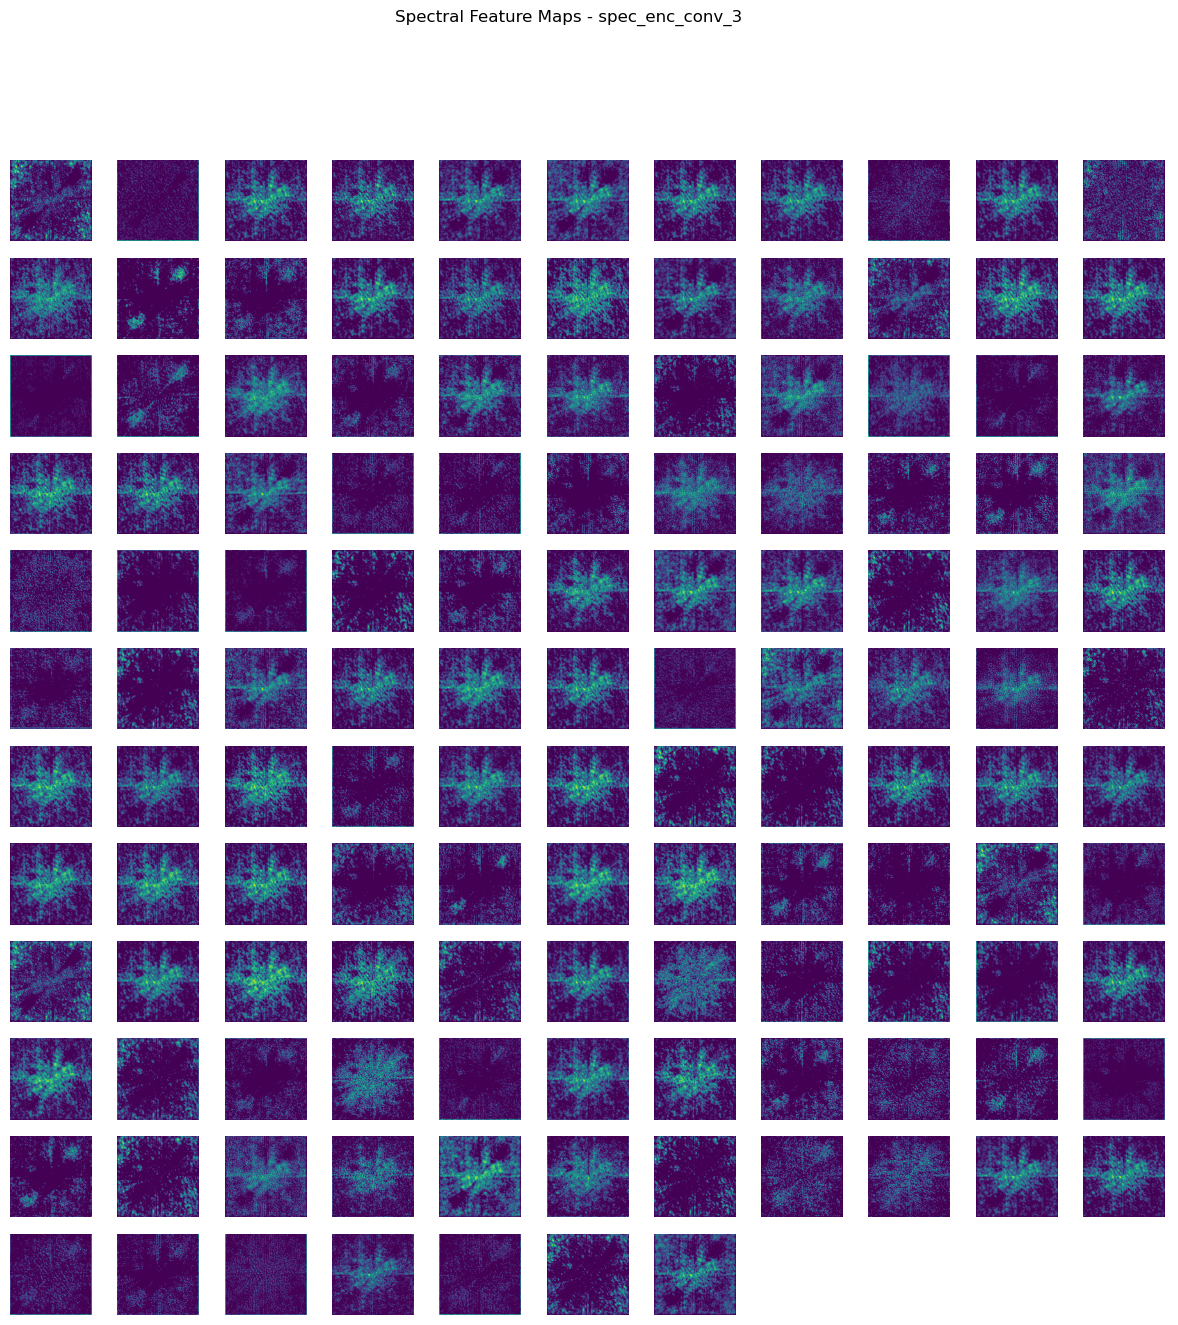

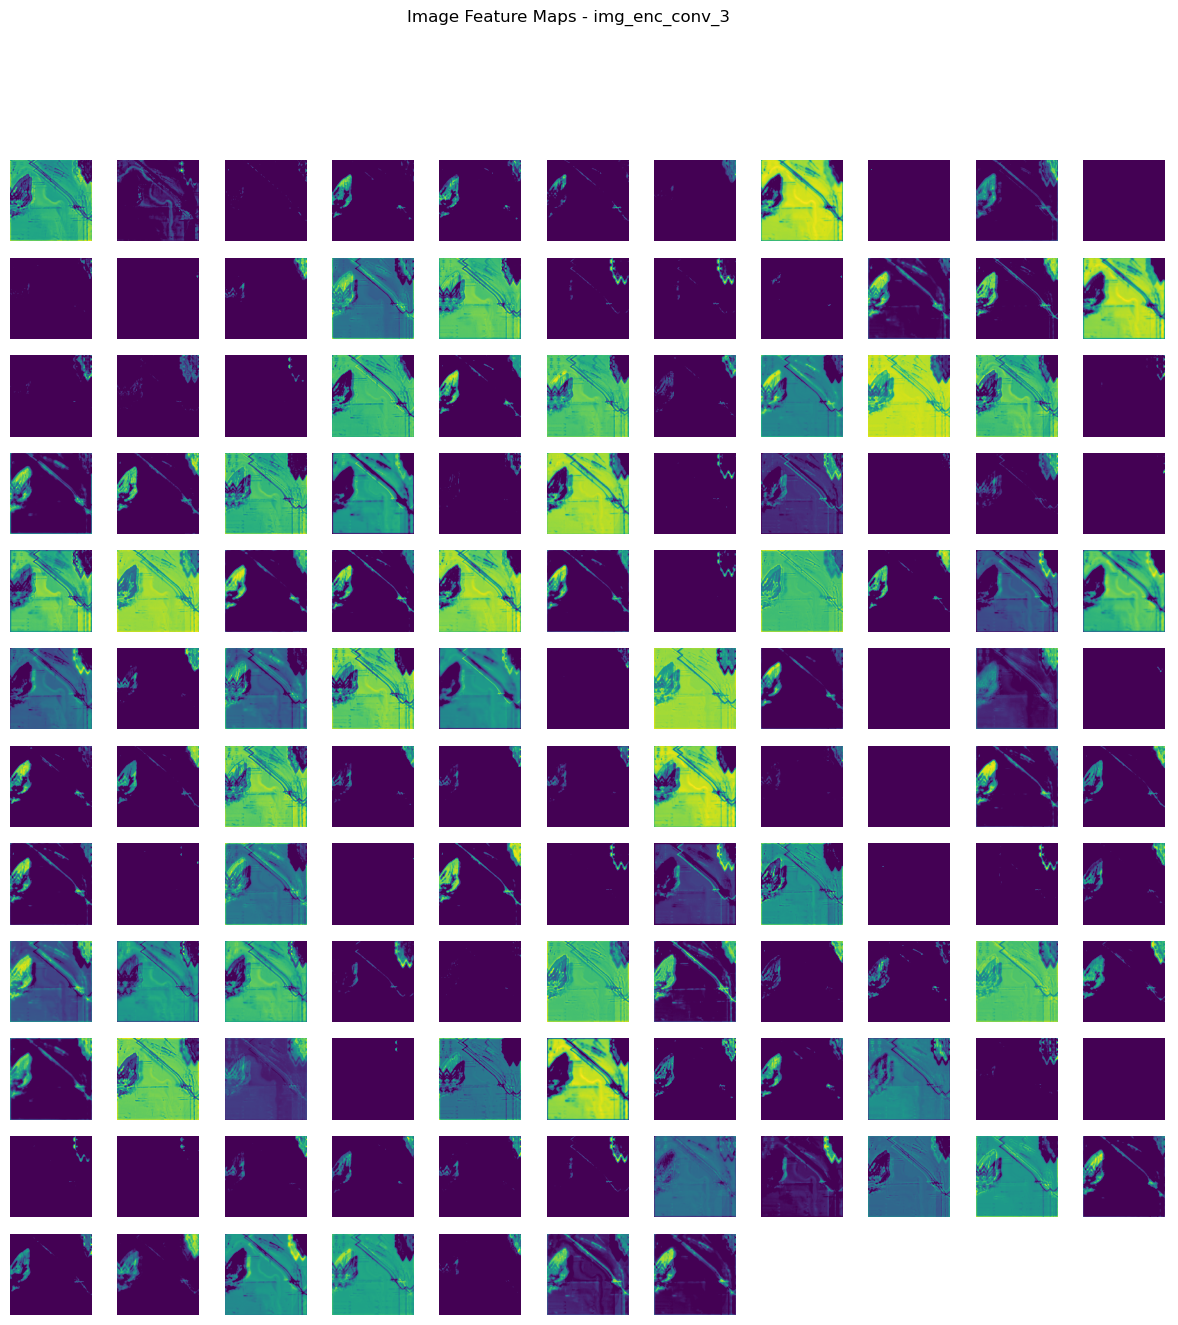

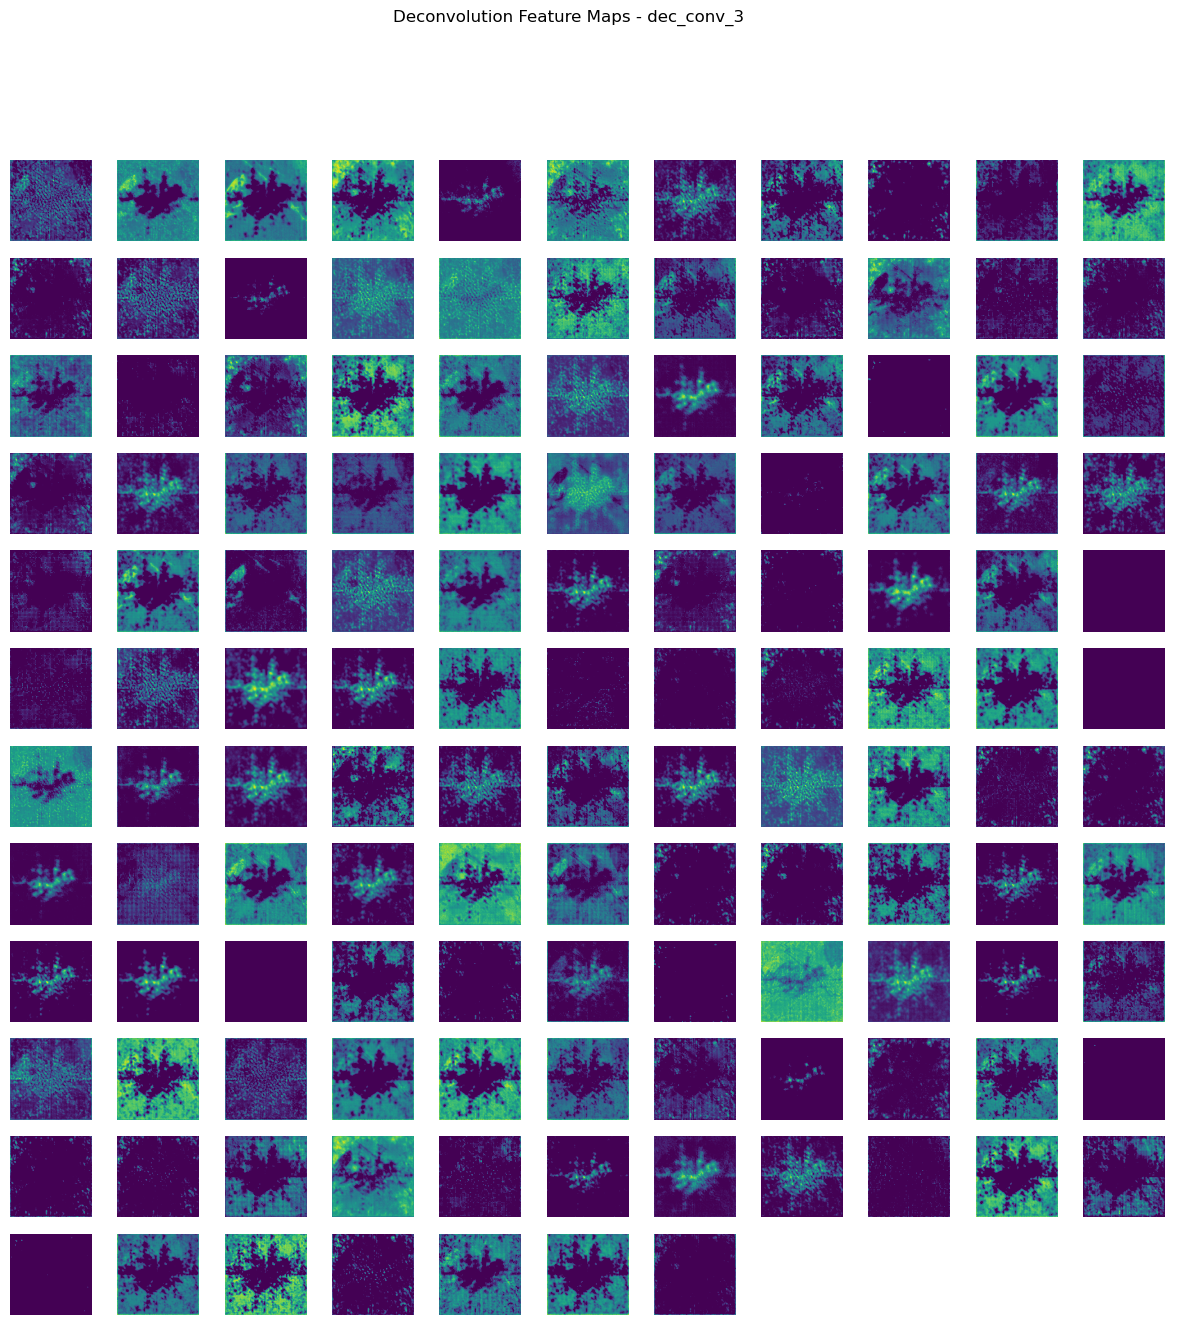

In [5]:
preds = results["results"][0]
spec_feature_map = results["spectral_encoding"][2]
img_feature_map = results["image_encoding"][2]
dec_conv = results["decoding"][2]

preds = torch.softmax(preds, dim=1)[:, 1]
preds = (preds > 0.5) * 1
preds = preds.cpu().numpy()
pred = np.ma.masked_where(preds == 0, preds)

plt.figure(figsize=(8, 8))
plt.imshow(pred[0], cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')
plt.show()

def visualize_feature_maps(feature_map, title="Feature Maps"):
    num_channels = feature_map.shape[1]
    
    # Determine the grid size (rows x cols)
    num_cols = int(math.sqrt(num_channels))
    num_rows = math.ceil(num_channels / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_channels):
        axes[i].imshow(feature_map[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(title)
    plt.show()

def visualize(data, title):
    print(data.shape)
    num_channels = data.shape[1]
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    for i in range(num_channels):
        axes[i].imshow(data[0, i].detach().cpu().numpy(), cmap='viridis')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()


visualize(X, "X")
visualize(ap, "ap")
visualize_feature_maps(spec_feature_map, title="Spectral Feature Maps - spec_enc_conv_3")
visualize_feature_maps(img_feature_map, title="Image Feature Maps - img_enc_conv_3")
visualize_feature_maps(dec_conv, title="Deconvolution Feature Maps - dec_conv_3")